In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/stock_data/NSE-TATAGLOBAL11.csv')

In [5]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [11]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03,1235.000000
mean,168.954858,171.429069,166.402308,168.736356,168.731053,2.604151e+06,4843.166502
std,51.499145,52.436761,50.542919,51.587384,51.544928,2.277028e+06,5348.919832
min,103.000000,104.600000,100.000000,102.600000,102.650000,1.001800e+05,128.040000
25%,137.550000,138.925000,135.250000,137.175000,137.225000,1.284482e+06,1801.035000
50%,151.500000,153.250000,149.500000,151.200000,151.100000,1.964885e+06,3068.510000
75%,169.000000,172.325000,166.700000,169.100000,169.500000,3.095788e+06,5852.600000
max,327.700000,328.750000,321.650000,325.950000,325.750000,2.919102e+07,55755.080000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1235 non-null   object 
 1   Open                  1235 non-null   float64
 2   High                  1235 non-null   float64
 3   Low                   1235 non-null   float64
 4   Last                  1235 non-null   float64
 5   Close                 1235 non-null   float64
 6   Total Trade Quantity  1235 non-null   float64
 7   Turnover (Lacs)       1235 non-null   float64
dtypes: float64(7), object(1)
memory usage: 77.3+ KB


In [13]:
df.corr()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Open,1.000000,0.998956,0.998776,0.997662,0.997704,0.367503,0.587026
High,0.998956,1.000000,0.998728,0.999130,0.999159,0.388798,0.605907
Low,0.998776,0.998728,1.000000,0.999008,0.999065,0.361695,0.582446
Last,0.997662,0.999130,0.999008,1.000000,0.999963,0.381269,0.599575
Close,0.997704,0.999159,0.999065,0.999963,1.000000,0.380801,0.599155
Total Trade Quantity,0.367503,0.388798,0.361695,0.381269,0.380801,1.000000,0.941976
Turnover (Lacs),0.587026,0.605907,0.582446,0.599575,0.599155,0.941976,1.000000


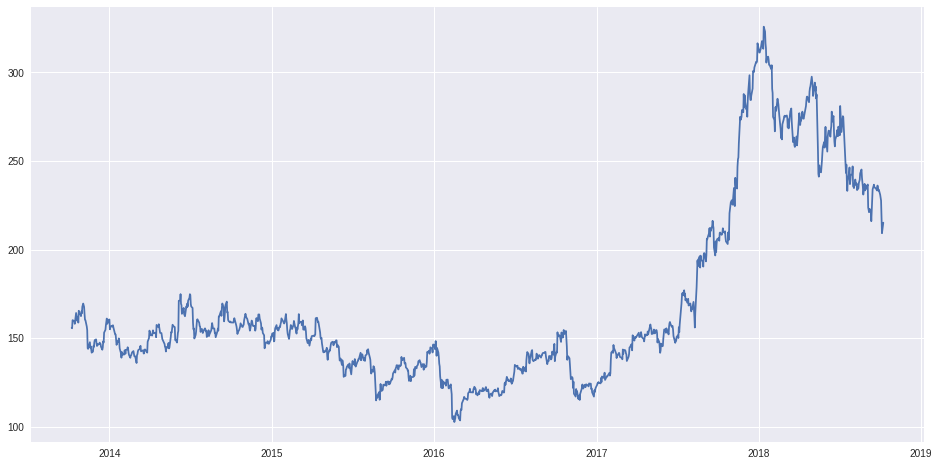

In [15]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [16]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

927/927 - 26s - loss: 0.0012 - 26s/epoch - 28ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


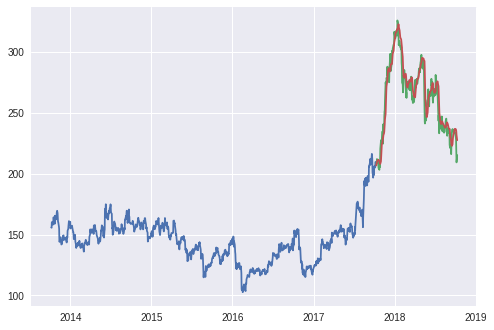

In [17]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])